# Data augmentation
- artificiellt skapa fler bilder
- slumpmässigt:
  - roterar till en viss grad (radianer)
  - translatera slumpmässigt
  - flippa horisontellt, vertikalt (spegla)
  - shear
  - ...

11501568/11490434 [==============================] - 0s 0us/step


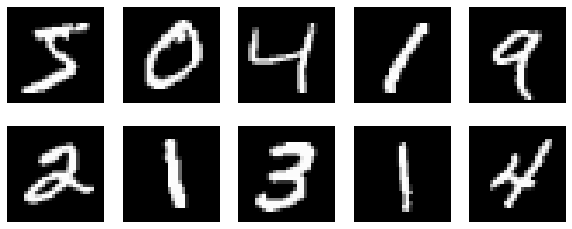

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()
y_train, y_test = y_train.ravel(), y_test.ravel()

def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")

plot_samples(X_train)

In [2]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
X_train.min(), X_train.max()

(0.0, 1.0)

## Train|val|test split

In [3]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1/6, random_state=42)

X_train_val = X_train_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_val = X_val[:,:,:,None]
X_test = X_test[:,:,:,None]

X_train_val.shape

(50000, 28, 28, 1)

## Data augmentation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=.2,
    zoom_range=.1,
    horizontal_flip=False,
    height_shift_range=.2,
    width_shift_range=.2
)

# don't augment validation and test data
test_image_generator = ImageDataGenerator()

train_val_generator = train_image_generator.flow(
    X_train_val, y_train_val, batch_size=32)

val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x7f0d5703e610>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x7f0d5a804d90>)

2
(32, 28, 28, 1)


array([1, 3, 8, 1, 8, 0, 3, 3, 1, 0, 9, 7, 0, 6, 7, 6, 1, 2, 6, 2, 8, 9,
       9, 4, 0, 2, 9, 6, 3, 8, 1, 6], dtype=uint8)

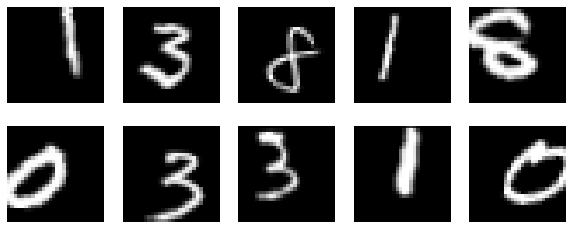

In [5]:
print(len(train_val_generator.next()))

sample_batch = train_val_generator.next()
print(sample_batch[0].shape) # 32 samples in a batch

plot_samples(sample_batch[0])
sample_batch[1]

## CNN model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam


def CNN_model(learning_rate=.001, drop_rate=.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    # the convolutional layers
    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, kernel_size=(
            3, 3), activation="relu", kernel_initializer="he_normal",
            input_shape=X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
    
    # MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax"))

    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])

    return model

model = CNN_model(drop_rate=.5)
model.summary()

2022-04-28 08:53:33.563554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 08:53:33.668949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 08:53:33.669719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 08:53:33.671528: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               20

## Train on augmented data

In [7]:
steps_per_epoch = int(len(X_train_val)/32)
validation_steps = int(len(X_val)/32)

steps_per_epoch, validation_steps

(1562, 312)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, restore_best_weights = True)

model.fit(
    train_val_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 100,
    callbacks = [early_stopper],
    validation_data = val_generator,
    validation_steps = validation_steps
)

2022-04-28 08:53:36.214476: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-04-28 08:53:37.411963: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1562/1562 [==============================] - 24s 11ms/step - loss: 0.6223 - acc: 0.7962 - val_loss: 0.1197 - val_acc: 0.9657
Epoch 2/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2518 - acc: 0.9196 - val_loss: 0.0911 - val_acc: 0.9727
Epoch 3/100
1562/1562 [==============================] - 18s 11ms/step - loss: 0.1974 - acc: 0.9377 - val_loss: 0.0703 - val_acc: 0.9798
Epoch 4/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1730 - acc: 0.9457 - val_loss: 0.0765 - val_acc: 0.9763
Epoch 5/100
1562/1562 [==============================] - 18s 11ms/step - loss: 0.1585 - acc: 0.9505 - val_loss: 0.0511 - val_acc: 0.9834
Epoch 6/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1448 - acc: 0.9552 - val_loss: 0.0557 - val_acc: 0.9831
Epoch 7/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1398 - acc: 0.9562 - val_loss: 0.0504 - val_acc: 0.9843
Epoch 8/100
1562/1562 [==============================

In [9]:
metrics = pd.DataFrame(model.history.history)

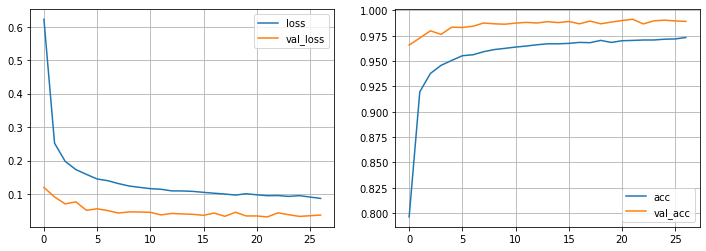

In [10]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], grid = True)

plot_metrics(metrics)

## Train on all training data

In [11]:
train_generator = train_image_generator.flow(
    X_train, y_train, batch_size=32)

In [12]:
model = CNN_model()
model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs = 15)

Epoch 1/15
1562/1562 [==============================] - 18s 11ms/step - loss: 0.6252 - acc: 0.7954
Epoch 2/15
1562/1562 [==============================] - 19s 12ms/step - loss: 0.2555 - acc: 0.9199
Epoch 3/15
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2021 - acc: 0.9350
Epoch 4/15
1562/1562 [==============================] - 19s 12ms/step - loss: 0.1798 - acc: 0.9431
Epoch 5/15
1562/1562 [==============================] - 16s 10ms/step - loss: 0.1582 - acc: 0.9509
Epoch 6/15
1562/1562 [==============================] - 19s 12ms/step - loss: 0.1525 - acc: 0.9526
Epoch 7/15
1562/1562 [==============================] - 16s 10ms/step - loss: 0.1411 - acc: 0.9559
Epoch 8/15
1562/1562 [==============================] - 19s 12ms/step - loss: 0.1338 - acc: 0.9577
Epoch 9/15
1562/1562 [==============================] - 16s 10ms/step - loss: 0.1252 - acc: 0.9609
Epoch 10/15
1562/1562 [==============================] - 20s 13ms/step - loss: 0.1245 - acc: 0.9611
Epoch 11/

## Evaluation

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       1.00      0.96      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



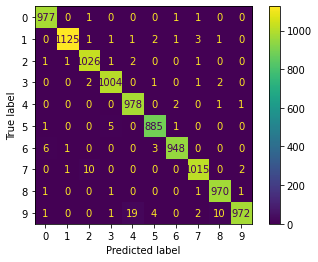

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()